### Implementation, training and testing of a simple Recurrent Neural Network for time series forecasting

In this notebook, we will implement a simple recurrent neural network (RNN) from scratch using only Python and NumPy.

A key characteristic of the neural networks you have encountered so far, like densely connected networks and convolutional networks, is their lack of memory. They process each input independently, without retaining any state across inputs. To handle sequences or time-series data using such networks, you must present the entire sequence at once, treating it as a single data point. For instance, as you’re reading this text, your brain is processing its content word by word while keeping memories of what was read before. This way, you can have a fluid representation of the overall content.


RNNs adopt the same principle. Basically, RNNs are a type of artificial neural network designed to work with sequential data. Unlike traditional feedforward neural networks, RNNs have internal connections that loop back, allowing information to persist across time steps. This makes RNNs particularly suited for tasks such as time series prediction, natural language processing, and sequence classification. In practice, a single sequence of $N$ elements will be considered as a single input to the RNN. A standard DNN would take that input as an $N$ size input and process all the elements at once in a single step. What changes in an RNN is that this single input is no longer processed in a single step, but the RNN loops over sequence elements internally.

An RNN consists of the following components:

Input Layer $\rightarrow$ Processes the sequential data.

Hidden Layer $\rightarrow$ Contains neurons with internal connections to model temporal dependencies.

Output Layer $\rightarrow$ Produces predictions.

The output at a time $t$ is defined as
$$
y_t = \mathbf{W}_y\cdot s_t + b_y
$$
with $\mathbf{W}_y$ the matrix of weights for the output, $b_y$ the bias for the output and $s_t$ the internal state at time $t$, given by
$$
s_t = \tanh\left(\mathbf{W}_x \cdot x_t + \mathbf{W}_s \cdot s_{t-1} + b_s\right)
$$
where $x_t$ is the input at time t, $s_{t-1}$ is the internal state at time $t-1$, $\mathbf{W}_x$ is the matrix of weights for the input, $\mathbf{W}_s$ is the matrix of weights for the internal state and $b_s$ is the bias for the internal state. Here, we have assumed a $\tanh$ activation function, but other types of activation function are possible.

In this notebook, we will code and train a simple RNN to predict a shifted sequence given a sequence of $n$ previous steps, i.e.
$$
(x_{t-n}, x_{t-(n-1)},\dots,x_{t-1})\rightarrow RNN \rightarrow (x_{t-(n-1)},x_{t-(n-2)},\dots,x_{t})
$$

This is called sequence-to-sequence coding, it is a very simple case, but still essential for time series forecasting. Indeed, the prediction at $t$ provided by the RNN will be used as an input for the next step for the RNN to predict the output at $t+1$ and so on. This is called "iterative prediction", but in this Notebook we will focus only on the prediction of a single time step given a time sequence.

First of all, let us import the essential modules.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

Now, we will generate synthetic data, using for example a sine wave. We will generate a given number of samples. Each sample will contain a sequence $x$ with a number of elements and a sequence $y$ with the same number of elements, equal to $x$ but shifted by one time step forward, with the same number of elements.

In [3]:
def generate_sine_wave(seq_length, num_samples):
    X = []
    y = []
    for _ in range(num_samples):
        start = np.random.rand() * 2 * np.pi
        x_seq = np.sin(np.linspace(start, start + 2 * np.pi, seq_length + 1))
        X.append(x_seq[:-1])  # Input sequence
        y.append(x_seq[1:])   # Target sequence
    return np.array(X), np.array(y)

Now we will use the previously coded function to generate the synthetic data

In [17]:
seq_length = 10
num_samples = 1000
X, y = generate_sine_wave(seq_length, num_samples)
#Check the shape and length of the arrays
print(X.shape)
print(y.shape)
print(len(X))
print(len(y))

(1000, 10)
(1000, 10)
1000
1000


The next cell contains the class that defines the RNN. It contains in particular the forward method (given an $x$ sequence, predict the time-shifted $y$ sequence) and the backward method to update the trainable parameters using a simple gradient descent algorithm.

In [9]:
# RNN Class
class SimpleRNN:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # Initialize weights and biases
        self.Wx = np.random.randn(hidden_size, input_size) * 0.01
        self.Ws = np.random.randn(hidden_size, hidden_size) * 0.01
        self.Wy = np.random.randn(output_size, hidden_size) * 0.01
        self.bs= np.zeros((hidden_size, 1))
        self.by = np.zeros((output_size, 1))

        self.intermediate_values = []  # To store intermediate values for backpropagation

    def forward(self, x_seq):
        s = np.zeros((self.hidden_size, 1))
        self.intermediate_values = []  # Clear the intermediate values for a new sequence
        y_pred = []

        for x_t in x_seq:
            x_t = x_t.reshape(-1, 1)  # Ensure x_t is a column vector
            s = np.tanh(np.dot(self.Wx, x_t) + np.dot(self.Ws, s) + self.bs)
            y_t = np.dot(self.Wy, s) + self.by
            y_pred.append(y_t)
            self.intermediate_values.append((s, x_t))  # Save internal state and input for backpropagation

        return np.array(y_pred).squeeze()

    # The next method computes the gradients of the loss function with respect to the
    # parameters of the model (Wx, Ws, Wy, bs, by) and updates them using gradient descent
    def backward(self, dLdy, learning_rate):
        dWx = np.zeros_like(self.Wx)
        dWs = np.zeros_like(self.Ws)
        dWy = np.zeros_like(self.Wy)
        dbs = np.zeros_like(self.bs)
        dby = np.zeros_like(self.by)
        ds_next = np.zeros((self.hidden_size, 1))

        # Loop Through Timesteps in Reverse
        # RNNs backpropagate through time, i.e.
        # it iterates backward through the sequence
        # to compute gradients at each time step
        for t in reversed(range(len(self.intermediate_values))):
            # Retrieve intermediate values values
            s, x_t = self.intermediate_values[t]
            
            # Compute gradient of output weights and biases
            # dLdy_t is the loss gradient for the output at time t
            dLdy_t = dLdy[t].reshape(-1, 1)  # Ensure dy is a column vector
            dWy += np.dot(dLdy_t, s.T)
            dby += dLdy_t
            
            #Backpropagate to the internal state
            ds = np.dot(self.Wy.T, dLdy_t) + ds_next
            # ds_tanh applies the derivative of the tanh activation function, (1−s^2)
            ds_tanh = (1 - s ** 2) * ds

            # Compute gradients for the input and the internal state weights and biases
            dWx += np.dot(ds_tanh, x_t.T)
            dWs += np.dot(ds_tanh, self.intermediate_values[t - 1][0].T) if t > 0 else 0
            dbs += ds_tanh
            
            # Update the gradient for the next time step
            ds_next = np.dot(self.Ws.T, ds_tanh)

        # Update weights and biases
        self.Wx -= learning_rate * dWx
        self.Ws -= learning_rate * dWs
        self.Wy -= learning_rate * dWy
        self.bs -= learning_rate * dbs
        self.by -= learning_rate * dby

The next step is the training of the RNN

In [10]:
# Train the RNN
# Select a seed for the random generator just to ensure that the results can be reproduced (for debugging purposes)
np.random.seed(42)
#Initialize the RNN
rnn = SimpleRNN(input_size=1, hidden_size=20, output_size=1)

#Select the number of epochs
epochs = 100

total_loss = []

#Select a learning rate
learning_rate = 0.01

for epoch in range(epochs):
    epoch_loss = 0
    for i in range(len(X)):
        x_seq = X[i]
        y_true = y[i]

        # Complete the forward pass
        y_pred = rnn.forward(x_seq)

        # Compute the loss using the mean equared error (MSE)
        loss = np.mean((y_pred - y_true) ** 2)
        
        #Add the loss to the epoch_loss
        epoch_loss += loss

        # Backward pass
        # Compute the gradient of the MSE loss with respect to the prediction y_pred
        dLdy = 2 * (y_pred - y_true) / len(y_true)
        # Update the model parameters using the backward method of the RNN class
        rnn.backward(dLdy, learning_rate)
    
    # Append the obtained loss to the total_loss list, normalizing by the number of samples
    total_loss.append(epoch_loss / len(X))
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss[-1]:.4f}")

Epoch 1/100, Loss: 0.2644
Epoch 2/100, Loss: 0.0742
Epoch 3/100, Loss: 0.0347
Epoch 4/100, Loss: 0.0297
Epoch 5/100, Loss: 0.0290
Epoch 6/100, Loss: 0.0289
Epoch 7/100, Loss: 0.0288
Epoch 8/100, Loss: 0.0288
Epoch 9/100, Loss: 0.0288
Epoch 10/100, Loss: 0.0287
Epoch 11/100, Loss: 0.0287
Epoch 12/100, Loss: 0.0287
Epoch 13/100, Loss: 0.0286
Epoch 14/100, Loss: 0.0286
Epoch 15/100, Loss: 0.0286
Epoch 16/100, Loss: 0.0285
Epoch 17/100, Loss: 0.0285
Epoch 18/100, Loss: 0.0284
Epoch 19/100, Loss: 0.0284
Epoch 20/100, Loss: 0.0283
Epoch 21/100, Loss: 0.0283
Epoch 22/100, Loss: 0.0282
Epoch 23/100, Loss: 0.0282
Epoch 24/100, Loss: 0.0281
Epoch 25/100, Loss: 0.0280
Epoch 26/100, Loss: 0.0279
Epoch 27/100, Loss: 0.0278
Epoch 28/100, Loss: 0.0277
Epoch 29/100, Loss: 0.0276
Epoch 30/100, Loss: 0.0275
Epoch 31/100, Loss: 0.0274
Epoch 32/100, Loss: 0.0273
Epoch 33/100, Loss: 0.0272
Epoch 34/100, Loss: 0.0271
Epoch 35/100, Loss: 0.0270
Epoch 36/100, Loss: 0.0269
Epoch 37/100, Loss: 0.0268
Epoch 38/1

Let us now visualize the training loss as a function of the number of epochs

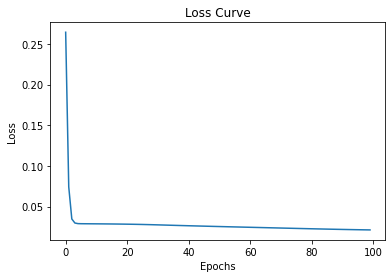

In [11]:
# Visualize the Loss Curve
plt.plot(total_loss)
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

Let us test our trained RNN on a single time sequence (num_samples=1)

In [12]:
# Test the RNN
# Visualize predictions on a new sine wave.
X_test, y_test = generate_sine_wave(seq_length, 1)
x_test, y_test = X_test[0], y_test[0]
y_pred = rnn.forward(x_test)

Plot the results...

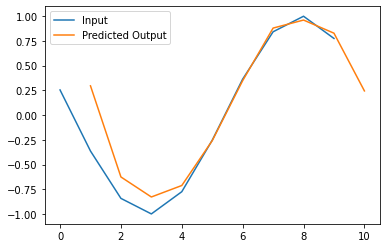

In [15]:
# Plot the input sequence and the predicted sequence.
# The predicted one is supposed to be the input sequence, but shifted by one time step forward
plt.plot(range(seq_length), x_test, label="Input")
plt.plot(range(1, seq_length+1), y_pred, label="Predicted Output")
plt.legend()
plt.show()

If you have time, you can try to code the iterative prediction, which means that you use now the predicted value as an input for the RNN to predict the next step and so on. What do you observe?